A quick tutorial on how to use the WindowGenerator Class from window_generator.py

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from window_generator import WindowGenerator

In [2]:
path = "/Users/eliassovikgunnarsson/Downloads/vix-daily_csv.csv"
df = pd.read_csv(path, header = 0, index_col= 0)
df.head()

,VIX Open,VIX High,VIX Low,VIX Close
Date,,,,
2004-01-02,17.96,18.68,17.54,18.22
2004-01-05,18.45,18.49,17.44,17.49
2004-01-06,17.66,17.67,16.19,16.73
2004-01-07,16.72,16.75,15.50,15.50
2004-01-08,15.42,15.68,15.32,15.61


<AxesSubplot: xlabel='Date'>

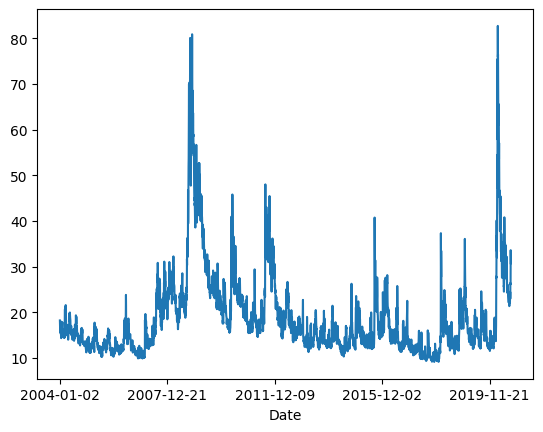

In [3]:
df['VIX Close'].plot()

In [4]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
df.head()

,VIX Open,VIX High,VIX Low,VIX Close
Date,,,,
2004-01-02,17.96,18.68,17.54,18.22
2004-01-05,18.45,18.49,17.44,17.49
2004-01-06,17.66,17.67,16.19,16.73
2004-01-07,16.72,16.75,15.50,15.50
2004-01-08,15.42,15.68,15.32,15.61


Create a window: Use 31 prior days of input data to forecast the next day value

Shift = 1 indicates that the value(s) to be predictes starts from one day after the input data. Label width specifies how many days to be predicted simultaneously.

In [5]:
w = WindowGenerator(input_width=30, label_width=1, shift=1, label_columns=['VIX Close'], train_df=train_df, val_df=val_df, test_df=test_df)
w

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['VIX Close']

Make a train dataset: resulting data set is a tensorflow dataset with shape : (batch, time, features). This applies also to train and val.

In [6]:
train = w.train
train.element_spec

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-18 11:05:54.146260: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-18 11:05:54.146953: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


(TensorSpec(shape=(None, 30, 4), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

If we want to convert the tf.dataset to a np.array. This is for example useful if we want to visualize results.

In [7]:
X_train = np.concatenate([x for x, y in train], axis = 0)
y_train = np.concatenate([y for x, y in train], axis = 0)
print(X_train.shape)
print(y_train.shape)

2023-04-18 11:05:54.345172: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(2909, 30, 4)
(2909, 1, 1)


For sliding window time series cross validation we can get the folds like this:
* This takes the train_df and splits it into n folds in sliding windows of fixed length.
* n_folds is specified when initializing the windowGenerator object, where n=5 is default.
* train_splits, and val_splits parameters makes the inter fold train/val split ratio. Default is 3, 1 which makes a ratio of 0.75
* Idea: Every parameter configuration must be trained and evaluated on every split. Then choose model configuration with highest average performance and lowest average standard deviation between folds.

In [22]:
folds = w.folds
for fold in folds:
    print("Within each fold we have two tf.datasets: ")
    print("Fold n training dataset: ", fold[0].element_spec)
    print("Fold n validation dataset: ", fold[1].element_spec)
    break

Within each fold we have two tf.datasets: 
Fold n training dataset:  (TensorSpec(shape=(None, 30, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))
Fold n validation dataset:  (TensorSpec(shape=(None, 30, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))


By default in when initializing the WindowGenerator Object, folds are determined to be scaled using StandardScaler:
* By setting scale = False in the initialization, scaling is not applied
* NB! scaling is only applied when generating folds. Thus, w.train will give a train dataset which is not scaled even if scale=True

If one were to use a RobustScaler:

In [23]:
w1 = WindowGenerator(input_width=30, label_width=1, shift=1, label_columns=['VIX Close'], train_df=train_df, val_df=val_df, test_df=test_df, scaler=RobustScaler)
folds = w1.folds
for fold in folds:
    print("Fold n training dataset: ", fold[0].element_spec)
    print("Fold n validation dataset: ", fold[0].element_spec)
    break

Fold n training dataset:  (TensorSpec(shape=(None, 30, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))
Fold n validation dataset:  (TensorSpec(shape=(None, 30, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))


If we want to use the WindowGenerator for a RandomFores Model for instance, this can be done by converting the tf.dataset into np.arrays in the same way as above OR generate folds like this: 

In [25]:
folds = w.np_folds

for fold in folds:
    train_X, train_y, val_X, val_y, = fold
    print("Within each fold we have four np.arrays: ")
    print("X train shape: ", train_X.shape)
    print("y train shape: ", train_y.shape)
    print("X val shape: ", val_X.shape)
    print("y val shape: ", val_y.shape)
    break

Within each fold we have four np.arrays: 
X train shape:  (1076, 30, 4)
y train shape:  (1076, 1, 1)
X val shape:  (337, 30, 4)
y val shape:  (337, 1, 1)
